# References to check 

> Hands-on Graph Neural Networks for Social Network Using PyTorch | by Awadelrahman M. A. Ahmed | Medium
https://awadrahman.medium.com/hands-on-graph-neural-networks-for-social-network-using-pytorch-30231c130b38

social_network_project/GCN_node_classification.ipynb at main · Jingting723/social_network_project · GitHub
https://github.com/Jingting723/social_network_project/blob/main/GCN_node_classification.ipynb


(3) Graph Neural Networks - YouTube
https://www.youtube.com/playlist?list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z

(3) Fake News Detection using Graphs with Pytorch Geometric - YouTube
https://www.youtube.com/watch?v=QAIVFr24FrA&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=22

fake_news_detection.ipynb - Colaboratory
https://colab.research.google.com/drive/1ZVZdehPPod6o4sF64QZa8I3NoSOH8MmC?usp=sharing


(3) Node Classification on Knowledge Graphs using PyTorch Geometric - YouTube
https://www.youtube.com/watch?v=ex2qllcVneY

knowledge_graphs_GNN.ipynb - Colaboratory
https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing#scrollTo=T8oB-KlJSaat

Tutorial Graph Neural Networks on Social Networks | Kaggle
https://www.kaggle.com/code/mahmoudhamza/tutorial-graph-neural-networks-on-social-networks/edit

In [ ]:
pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 12.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=4e29b30e037f551e3e2bee51ae8405be81c9511e7be02dc9efcf09f04eb728a4
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric


In [ ]:
import pandas as pd 
import numpy as np
import collections

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, SGConv

import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/vanderbilt/social/project')

Mounted at /content/drive


In [ ]:
users = pd.read_csv("users.csv", header= None)
edges = pd.read_csv("edges.csv", header = None)
df = pd.read_csv("df.csv", index_col = 0)

In [ ]:
users = users.reset_index()

In [ ]:
users.columns = ["userid", 'username']

In [ ]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [ ]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [ ]:
# users['random_feat'] = np.random.choice(2, size = users.shape[0])

In [ ]:
node_features = df[["comment_karma", "link_karma"]]
num_classes = 2

In [ ]:
node_features

,comment_karma,link_karma
that_90s_guy,31343.0,20684.0
AutoModerator,1000.0,1000.0
scumbagdetector15,18369.0,1.0
csch2,1981.0,2622.0
PlayerofVideoGames,18476.0,473.0
...,...,...
Lanky_Information825,326.0,3.0
xebeka6808,4631.0,765.0
HumanJenoM,8117.0,505.0
mvandemar,4467.0,2391.0


In [ ]:
# Convert to numpy
x = torch.tensor(node_features.values)
x.shape # [num_nodes x num_features]

torch.Size([613, 2])

In [ ]:
df

,comment_karma,link_karma,avg_upvotes
that_90s_guy,31343.0,20684.0,1503.390000
AutoModerator,1000.0,1000.0,1.004695
scumbagdetector15,18369.0,1.0,170.600000
csch2,1981.0,2622.0,136.000000
PlayerofVideoGames,18476.0,473.0,57.000000
...,...,...,...
Lanky_Information825,326.0,3.0,5.000000
xebeka6808,4631.0,765.0,5.000000
HumanJenoM,8117.0,505.0,3.000000
mvandemar,4467.0,2391.0,2.000000


In [ ]:
# users['labels'] = np.random.choice(2, size = users.shape[0])

In [ ]:
median_upvotes = np.median(df.avg_upvotes)

In [ ]:
median_upvotes

3.0

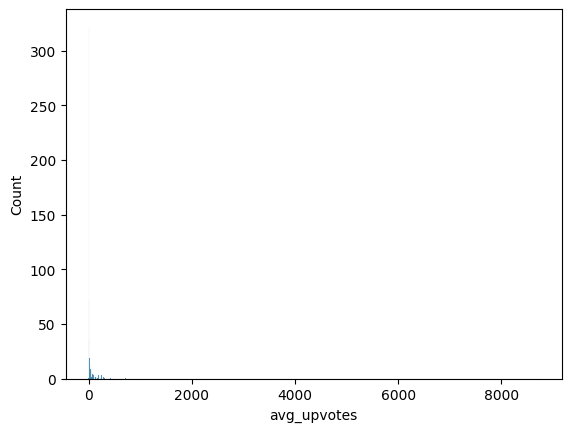

In [ ]:
# import seaborn as sns 
# sns.histplot(df.avg_upvotes);

In [ ]:
labels = [1 if upvotes >= median_upvotes else 0 for upvotes in df['avg_upvotes']]

In [ ]:
collections.Counter(labels)

Counter({1: 334, 0: 279})

In [ ]:
y = torch.tensor(labels, dtype=torch.long)
y.shape

torch.Size([613])

In [ ]:
edges[['source', 'dest']] = edges[0].str.split("###", expand = True)

In [ ]:
edges

,0,source,dest
0,AutoModerator###that_90s_guy,AutoModerator,that_90s_guy
1,scumbagdetector15###that_90s_guy,scumbagdetector15,that_90s_guy
2,csch2###scumbagdetector15,csch2,scumbagdetector15
3,scumbagdetector15###csch2,scumbagdetector15,csch2
4,PlayerofVideoGames###scumbagdetector15,PlayerofVideoGames,scumbagdetector15
...,...,...,...
1669,flossraptor###Alternative_Ad_9702,flossraptor,Alternative_Ad_9702
1670,Timofey_###Alternative_Ad_9702,Timofey_,Alternative_Ad_9702
1671,Alternative_Ad_9702###Alternative_Ad_9702,Alternative_Ad_9702,Alternative_Ad_9702
1672,xebeka6808###Alternative_Ad_9702,xebeka6808,Alternative_Ad_9702


In [ ]:
edges = edges[['source', 'dest']]

In [ ]:
edges['source']

0             AutoModerator
1         scumbagdetector15
2                     csch2
3         scumbagdetector15
4        PlayerofVideoGames
               ...         
1669            flossraptor
1670               Timofey_
1671    Alternative_Ad_9702
1672             xebeka6808
1673             xebeka6808
Name: source, Length: 1674, dtype: object

In [ ]:
# Perform merge to obtain the edges from users and movies:
edges_source_id = pd.merge(edges['source'], users,
                            left_on='source', right_on='username', how='left')

In [ ]:
users

,userid,username
0,0,that_90s_guy
1,1,AutoModerator
2,2,scumbagdetector15
3,3,csch2
4,4,PlayerofVideoGames
...,...,...
608,608,Lanky_Information825
609,609,xebeka6808
610,610,HumanJenoM
611,611,mvandemar


In [ ]:
edges_source_id = torch.from_numpy(edges_source_id['userid'].values)

In [ ]:
edges_source_id

tensor([  1,   2,   3,  ..., 606, 609, 609])

In [ ]:
edges_dest_id = pd.merge(edges['dest'], users,
                            left_on='dest', right_on='username', how='left')
edges_dest_id = torch.from_numpy(edges_dest_id['userid'].values)


In [ ]:
edges_dest_id

tensor([  0,   0,   2,  ..., 606, 606, 606])

In [ ]:
# # With this, we are ready to construct our `edge_index` in COO format
# # following PyG semantics:
edge_source_dest = torch.stack([edges_source_id, edges_dest_id], dim=0)
# assert edge_index_user_to_movie.size() == (2, 100836)


In [ ]:
x = torch.tensor(x.float())
y = torch.tensor(y).ravel()

<ipython-input-30-4bfdc6061317>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x.float())
<ipython-input-30-4bfdc6061317>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).ravel()


In [ ]:
y.shape

torch.Size([613])

In [ ]:
data = Data(x= x , edge_index=edge_source_dest, y=y, num_classes = 2)

In [ ]:
data

Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=2)

In [ ]:
from torch_geometric.transforms import RandomNodeSplit as masking

Probably this is not the best way to split. Probably splitting using random links would be better

In [ ]:
msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.2)
data=msk(data)
print(data)
print()
print("training samples",torch.sum(data.train_mask).item())
print("validation samples",torch.sum(data.val_mask ).item())
print("test samples",torch.sum(data.test_mask ).item())

# Hands-on Graph Neural Networks for Social Network Using PyTorch | by Awadelrahman M. A. Ahmed | Medium
# https://awadrahman.medium.com/hands-on-graph-neural-networks-for-social-network-using-pytorch-30231c130b38


Data(x=[613, 2], edge_index=[2, 1674], y=[613], num_classes=2, train_mask=[613], val_mask=[613], test_mask=[613])

training samples 367
validation samples 123
test samples 123


In [ ]:
num_of_feat=data.num_node_features

In [ ]:
num_of_feat

2

## Node classification

In [ ]:
class SocialGNN(torch.nn.Module):
    def __init__(self,num_of_feat,f):
        super(SocialGNN, self).__init__()
        self.conv1 = GCNConv(num_of_feat, f)
        self.conv2 = GCNConv(f, 2)
    def forward(self, data):
        x = data.x.float()
        edge_index =  data.edge_index
        x = self.conv1(x=x, edge_index=edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def masked_loss(predictions,labels,mask):
    mask=mask.float()
    mask=mask/torch.mean(mask)
    loss=criterion(predictions,labels)
    loss=loss*mask
    loss=torch.mean(loss)
    return (loss)    
def masked_accuracy(predictions,labels,mask):
    mask=mask.float()
    mask/=torch.mean(mask)
    accuracy=(torch.argmax(predictions,axis=1)==labels).long()
    accuracy=mask*accuracy
    accuracy=torch.mean(accuracy)
    return (accuracy)

In [ ]:
def train_social(net,data,epochs=10,lr=0.01):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 00001
    best_accuracy=0.0
    train_losses=[]
    train_accuracies=[]
    val_losses=[]
    val_accuracies=[]
    test_losses=[]
    test_accuracies=[]
    for ep in range(epochs+1):
        # print(ep)
        optimizer.zero_grad()
        out=net(data)
        loss=masked_loss(predictions=out,
                         labels=data.y,
                         mask=data.train_mask)
        loss.backward()
        optimizer.step()
        train_losses+=[loss.detach().numpy()]
        train_accuracy=masked_accuracy(predictions=out,
                                       labels=data.y, 
                                       mask=data.train_mask)
        train_accuracies+=[train_accuracy]
        val_loss=masked_loss(predictions=out,
                             labels=data.y, 
                             mask=data.val_mask)
        # print(loss, val_loss)
        val_losses+=[val_loss.detach().numpy()]
        # print(val_losses)
        val_accuracy=masked_accuracy(predictions=out,
                                     labels=data.y, 
                                     mask=data.val_mask)
        val_accuracies+=[val_accuracy]
        # test_accuracy=masked_accuracy(predictions=out,
        #                               labels=data.y, 
        #                               mask=data.test_mask)
        # test_accuracies+=[test_accuracy]
        if np.round(val_accuracy,4)> np.round(best_accuracy ,4):
            # print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}, Test_Accuracy: {:.4f}"
            #           .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy,  test_accuracy))
            
            print("Epoch {}/{}, Train_Loss: {:.4f}, Train_Accuracy: {:.4f}, Val_Accuracy: {:.4f}"
            .format(ep+1,epochs, loss.item(), train_accuracy, val_accuracy))

            best_accuracy=val_accuracy
    plt.plot(val_losses)
    # plt.plot(train_losses)  
    # plt.plot(test_losses)  
    plt.show()
    # plt.plot(train_accuracies) 
    plt.plot(val_accuracies)
    # plt.plot(test_accuracies) 
    plt.show()

Epoch 1/50, Train_Loss: 9128.8789, Train_Accuracy: 0.4360, Val_Accuracy: 0.3984
Epoch 2/50, Train_Loss: 1674.0852, Train_Accuracy: 0.5395, Val_Accuracy: 0.5772
Epoch 4/50, Train_Loss: 1163.4524, Train_Accuracy: 0.5668, Val_Accuracy: 0.6179
Epoch 16/50, Train_Loss: 245.8028, Train_Accuracy: 0.6049, Val_Accuracy: 0.6423
Epoch 20/50, Train_Loss: 5.2570, Train_Accuracy: 0.5559, Val_Accuracy: 0.6504


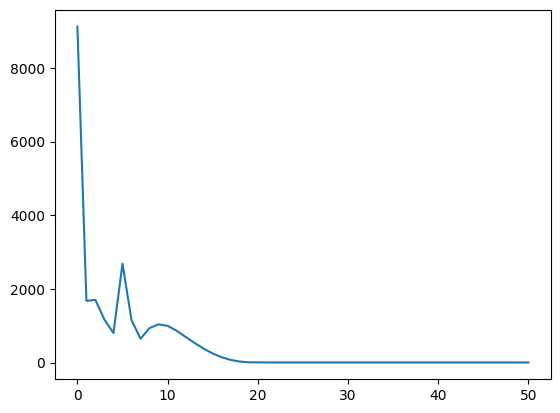

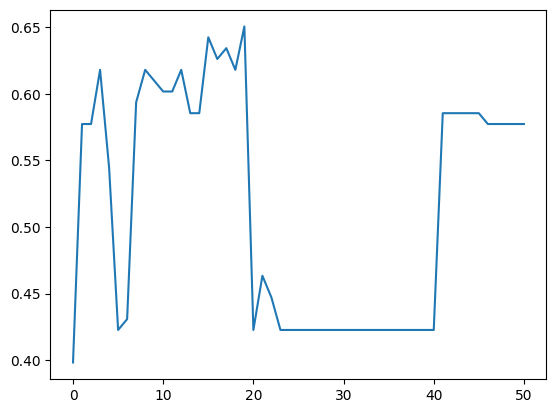

In [ ]:
net=SocialGNN(num_of_feat=num_of_feat,f=16)
criterion=nn.CrossEntropyLoss()
train_social(net,data,epochs=50,lr=0.1)

In [ ]:
# from torch_geometric.utils import train_test_split_edges

# # Split the data into training, validation, and testing sets
# train_data, val_data, test_data = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)


## My implementation

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
model = GCN()#
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

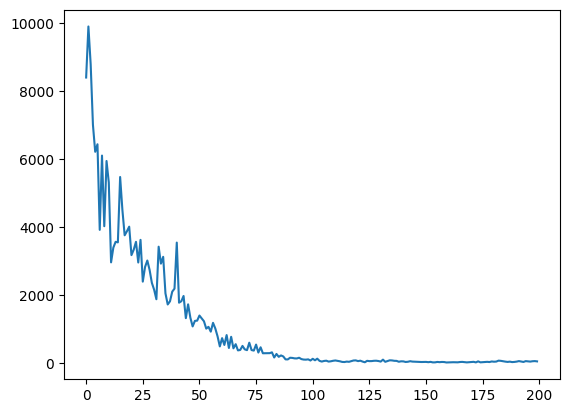

In [ ]:
plt.plot(loss_values);

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6585


## Hyperparameter tuning  

- Number of layers:  1, 2, and also 5
- L2 regularization on the neural network weight matrices/parameters
(i.e., weight decay parameter: 0, 1e-4, and 1e-2)
- Learning rate given as input to torch.optim.Adam(): 1e-5 and 1e-2

I will calculate the mean and standard deviation of 3 runs 

### 2 layers implemenattion

In [ ]:
# Define the ranges for each hyperparameter
weight_decays = [0, 1e-4, 1e-2] 
learning_rates = [1e-5, 1e-2]

# Define the number of times to repeat for each set of hyperparameters
num_repeats = 3

# Initialize a dictionary to store the results
results = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          
          # Initialize the model and optimizer with the current hyperparameters
          model = GCN()
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

          # Train the model and get the accuracy for each repeat
          acc_list = []
          for repeat in range(num_repeats):
              model.train()
              for epoch in range(200):
                  optimizer.zero_grad()
                  out = model(data)
                  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
                  loss.backward()
                  optimizer.step()

              model.eval()
              pred = model(data).argmax(dim=1)
              correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
              acc = int(correct) / int(data.val_mask.sum())
              acc_list.append(acc)

          # Calculate the mean and standard deviation of accuracy for the current hyperparameters
          acc_mean = round(np.mean(acc_list),4)
          acc_std = round(np.std(acc_list),4)
          
          # Store the results in the dictionary
          results[(weight_decay,learning_rate)] = (acc_mean, acc_std)


In [ ]:
results

{(0, 1e-05): (0.5718, 0.0038),
 (0, 0.01): (0.6558, 0.0213),
 (0.0001, 1e-05): (0.5772, 0.0),
 (0.0001, 0.01): (0.6206, 0.0213),
 (0.01, 1e-05): (0.4228, 0.0),
 (0.01, 0.01): (0.6341, 0.0289)}

## One layer implementation 

In [ ]:
class GCN_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
# Initialize a dictionary to store the results
results_1L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          
          # Initialize the model and optimizer with the current hyperparameters
          model = GCN_1()
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

          # Train the model and get the accuracy for each repeat
          acc_list = []
          for repeat in range(num_repeats):
              model.train()
              for epoch in range(200):
                  optimizer.zero_grad()
                  out = model(data)
                  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
                  loss.backward()
                  optimizer.step()

              model.eval()
              pred = model(data).argmax(dim=1)
              correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
              acc = int(correct) / int(data.val_mask.sum())
              acc_list.append(acc)

          # Calculate the mean and standard deviation of accuracy for the current hyperparameters
          acc_mean = round(np.mean(acc_list),4)
          acc_std = round(np.std(acc_list),4)
          
          # Store the results in the dictionary
          results_1L[(weight_decay,learning_rate)] = (acc_mean, acc_std)


In [ ]:
results_1L

{(0, 1e-05): (0.3984, 0.0),
 (0, 0.01): (0.4959, 0.0898),
 (0.0001, 1e-05): (0.4228, 0.0),
 (0.0001, 0.01): (0.6233, 0.0077),
 (0.01, 1e-05): (0.4011, 0.0038),
 (0.01, 0.01): (0.561, 0.0415)}

## Five layers implementation 

In [ ]:
class GCN_5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 320)
        self.conv2 = GCNConv(320, 240)
        self.conv3 = GCNConv(240, 120)
        self.conv4 = GCNConv(120, 16)
        self.conv5 = GCNConv(16, data.num_classes)
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv5(x, edge_index)


        return F.log_softmax(x, dim=1)

In [ ]:
# Initialize a dictionary to store the results
results_5L = {}

# Loop over all possible combinations of hyperparameters
for weight_decay in weight_decays:
      for learning_rate in learning_rates:
          
          # Initialize the model and optimizer with the current hyperparameters
          model = GCN_5()
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

          # Train the model and get the accuracy for each repeat
          acc_list = []
          for repeat in range(num_repeats):
              model.train()
              for epoch in range(200):
                  optimizer.zero_grad()
                  out = model(data)
                  loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
                  loss.backward()
                  optimizer.step()

              model.eval()
              pred = model(data).argmax(dim=1)
              correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
              acc = int(correct) / int(data.val_mask.sum())
              acc_list.append(acc)

          # Calculate the mean and standard deviation of accuracy for the current hyperparameters
          acc_mean = np.mean(acc_list)
          acc_std = np.std(acc_list)
          
          # Store the results in the dictionary
          results_5L[(weight_decay,learning_rate)] = (acc_mean, acc_std)


In [ ]:
results_5L

{(0, 1e-05): (0.5311653116531165, 0.013818481066647102),
 (0, 0.01): (0.5365853658536586, 0.0),
 (0.0001, 1e-05): (0.5663956639566395, 0.03137083171487864),
 (0.0001, 0.01): (0.5365853658536586, 0.0),
 (0.01, 1e-05): (0.4878048780487805, 0.034493013716416956),
 (0.01, 0.01): (0.5365853658536586, 0.0)}

In [ ]:
import pandas as pd
combined_dict = {}
combined_dict.update({1: results_1L})
combined_dict.update({2: results})
combined_dict.update({5: results_5L})

# Convert the dictionary into a pandas DataFrame
rows = []
for dict_type, inner_dict in combined_dict.items():
    for key, value in inner_dict.items():
        rows.append((dict_type, key, value[0], value[1]))

df = pd.DataFrame(rows, columns=['Layers', 'WD_LR', 'accuracy_mean', 'accuracy_std_dev'])

In [ ]:
df

,Layers,WD_LR,accuracy_mean,accuracy_std_dev
0,1,"(0, 1e-05)",0.398400,0.000000
1,1,"(0, 0.01)",0.495900,0.089800
2,1,"(0.0001, 1e-05)",0.422800,0.000000
3,1,"(0.0001, 0.01)",0.623300,0.007700
4,1,"(0.01, 1e-05)",0.401100,0.003800
5,1,"(0.01, 0.01)",0.561000,0.041500
6,2,"(0, 1e-05)",0.571800,0.003800
7,2,"(0, 0.01)",0.655800,0.021300
8,2,"(0.0001, 1e-05)",0.577200,0.000000
9,2,"(0.0001, 0.01)",0.620600,0.021300


In [ ]:
sorted_df = df.sort_values(by=['accuracy_mean'], ascending=False)
sorted_df

,Layers,WD_LR,accuracy_mean,accuracy_std_dev
7,2,"(0, 0.01)",0.655800,0.021300
11,2,"(0.01, 0.01)",0.634100,0.028900
3,1,"(0.0001, 0.01)",0.623300,0.007700
9,2,"(0.0001, 0.01)",0.620600,0.021300
8,2,"(0.0001, 1e-05)",0.577200,0.000000
6,2,"(0, 1e-05)",0.571800,0.003800
14,5,"(0.0001, 1e-05)",0.566396,0.031371
5,1,"(0.01, 0.01)",0.561000,0.041500
15,5,"(0.0001, 0.01)",0.536585,0.000000
13,5,"(0, 0.01)",0.536585,0.000000


## Evaluate on the test data

In [ ]:
# based on the sorted df, best hyperparameters are 0.01 and 0 and 2 layers 

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0)

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6098


## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(data.y[data.test_mask], pred[data.test_mask])

In [ ]:
import seaborn as sns 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

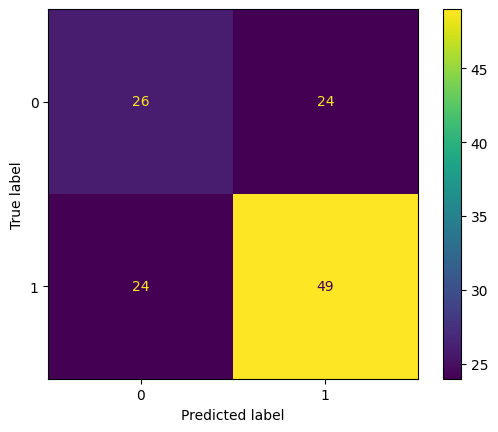

In [ ]:
disp.plot();

7. [25 points] Simplified Graph Convolution
Another simplified “graph neural network” is the Simplified Graph Convolution (SGC)
model. Actually, SGC removes the nonlinearities of the neural network model and
shows how we can then collapse the multiple linear layers to just one. https://
github.com/pyg-team/pytorch_geometric/blob/master/examples/sgc.py Then create another version of the example code that utilizes the SGConv instead of GCNConv
in the network model class. Obtain the results for this method after having varied
the value of “K” with 1, 2, and 3. Specifically, in the example code on line 18 it has:
self.conv1 = SGConv(data.num features, data.num classes, K=2, cached=True)
This is where you can vary the value of “K” as discussed in the lecture

K = 2

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(data.num_features, data.num_classes, K=2,
                            cached=True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(), data
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    out, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = out[mask].argmax(1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
          f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Train: 0.5531, Val: 0.5447, Test: 0.6098
Epoch: 002, Train: 0.6049, Val: 0.6423, Test: 0.6260
Epoch: 003, Train: 0.4687, Val: 0.6423, Test: 0.6260
Epoch: 004, Train: 0.4687, Val: 0.6423, Test: 0.6260
Epoch: 005, Train: 0.4687, Val: 0.6423, Test: 0.6260
Epoch: 006, Train: 0.6049, Val: 0.6423, Test: 0.6260
Epoch: 007, Train: 0.5940, Val: 0.6423, Test: 0.6260
Epoch: 008, Train: 0.5640, Val: 0.6423, Test: 0.6260
Epoch: 009, Train: 0.5640, Val: 0.6423, Test: 0.6260
Epoch: 010, Train: 0.5640, Val: 0.6423, Test: 0.6260
Epoch: 011, Train: 0.5640, Val: 0.6423, Test: 0.6260
Epoch: 012, Train: 0.5613, Val: 0.6423, Test: 0.6260
Epoch: 013, Train: 0.5586, Val: 0.6423, Test: 0.6260
Epoch: 014, Train: 0.5886, Val: 0.6423, Test: 0.6260
Epoch: 015, Train: 0.4687, Val: 0.6423, Test: 0.6260
Epoch: 016, Train: 0.4687, Val: 0.6423, Test: 0.6260
Epoch: 017, Train: 0.4932, Val: 0.6423, Test: 0.6260
Epoch: 018, Train: 0.5613, Val: 0.6423, Test: 0.6260
Epoch: 019, Train: 0.5368, Val: 0.6423, Test: 

K = 1

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(data.num_features, data.num_classes, K=1,
                            cached=True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(), data
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    out, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = out[mask].argmax(1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
          f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Train: 0.4605, Val: 0.4553, Test: 0.4065
Epoch: 002, Train: 0.4605, Val: 0.4634, Test: 0.4146
Epoch: 003, Train: 0.4196, Val: 0.4634, Test: 0.4146
Epoch: 004, Train: 0.5313, Val: 0.5366, Test: 0.5935
Epoch: 005, Train: 0.5313, Val: 0.5366, Test: 0.5935
Epoch: 006, Train: 0.5313, Val: 0.5366, Test: 0.5935
Epoch: 007, Train: 0.5395, Val: 0.5447, Test: 0.6016
Epoch: 008, Train: 0.5531, Val: 0.5528, Test: 0.6098
Epoch: 009, Train: 0.6158, Val: 0.6179, Test: 0.6098
Epoch: 010, Train: 0.6158, Val: 0.6341, Test: 0.6423
Epoch: 011, Train: 0.5995, Val: 0.6341, Test: 0.6423
Epoch: 012, Train: 0.5913, Val: 0.6341, Test: 0.6423
Epoch: 013, Train: 0.5368, Val: 0.6341, Test: 0.6423
Epoch: 014, Train: 0.5204, Val: 0.6341, Test: 0.6423
Epoch: 015, Train: 0.5504, Val: 0.6341, Test: 0.6423
Epoch: 016, Train: 0.5831, Val: 0.6341, Test: 0.6423
Epoch: 017, Train: 0.6076, Val: 0.6341, Test: 0.6423
Epoch: 018, Train: 0.6022, Val: 0.6341, Test: 0.6423
Epoch: 019, Train: 0.6267, Val: 0.6423, Test: 

K = 3

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(data.num_features, data.num_classes, K=3,
                            cached=True)

    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net(), data
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()
    out, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = out[mask].argmax(1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


best_val_acc = test_acc = 0
for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, '
          f'Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Train: 0.5395, Val: 0.5366, Test: 0.5854
Epoch: 002, Train: 0.5395, Val: 0.5610, Test: 0.6179
Epoch: 003, Train: 0.4687, Val: 0.5610, Test: 0.6179
Epoch: 004, Train: 0.4687, Val: 0.5610, Test: 0.6179
Epoch: 005, Train: 0.4687, Val: 0.5610, Test: 0.6179
Epoch: 006, Train: 0.5368, Val: 0.5610, Test: 0.6179
Epoch: 007, Train: 0.5559, Val: 0.5610, Test: 0.6179
Epoch: 008, Train: 0.5559, Val: 0.5610, Test: 0.6179
Epoch: 009, Train: 0.5586, Val: 0.5610, Test: 0.6179
Epoch: 010, Train: 0.5559, Val: 0.5610, Test: 0.6179
Epoch: 011, Train: 0.5559, Val: 0.5610, Test: 0.6179
Epoch: 012, Train: 0.5531, Val: 0.5610, Test: 0.6179
Epoch: 013, Train: 0.5313, Val: 0.5610, Test: 0.6179
Epoch: 014, Train: 0.5886, Val: 0.6341, Test: 0.5447
Epoch: 015, Train: 0.4687, Val: 0.6341, Test: 0.5447
Epoch: 016, Train: 0.4687, Val: 0.6341, Test: 0.5447
Epoch: 017, Train: 0.5804, Val: 0.6341, Test: 0.5447
Epoch: 018, Train: 0.5395, Val: 0.6341, Test: 0.5447
Epoch: 019, Train: 0.5559, Val: 0.6341, Test: 

8. [25 points] Induced sparsity on the graph
Investigate the format of ”data.edge index” which holds the edge information. Run
the same as part 4 above, but this time we will remove some edges randomly from the
graph and also print the final validation accuracy in addition to plotting the training
loss. You can modify this edge list variable to remove a random 5%, 25%, 50%, and
95% percentage of the links in the graph. Please note that “dropout adj” in PyG is not
what we’re looking for here, as this randomly drops edges throughout training similar
to how traditional dropout works. Instead, we are looking to completely remove them
from the edge list prior to training to simulate the result of going from full graph,
to nearly no connections left between the nodes (i.e., approaching a fully connected
neural network instead of GNN). 

In [ ]:
data.edge_index

tensor([[  1,   2,   3,  ..., 606, 609, 609],
        [  0,   0,   2,  ..., 606, 606, 606]])

In [ ]:
import random
remove_percent = 0.25

e = data.edge_index
m = e.shape[1]
keep = random.sample(range(m),int(m*(1-remove_percent)))
e_reduced = e[:,keep]
e_reduced.shape

torch.Size([2, 1255])

In [ ]:
data.edge_index = e_reduced
data.edge_index.shape

torch.Size([2, 1255])

In [ ]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

model.train()
loss_values = []
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

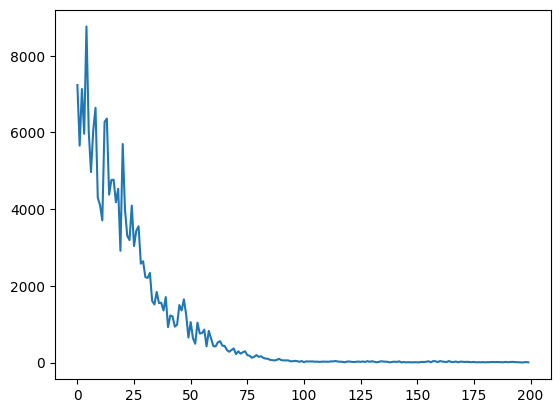

In [ ]:
plt.plot(loss_values);

## LOOP :) 

1674
1674
1590
1590
1255
1255
837
837
83
83


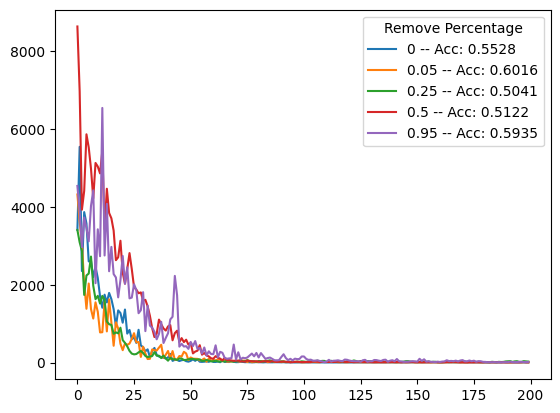

In [ ]:
remove_percent = [0, 0.05, 0.25, 0.5, 0.95]

for i in remove_percent: 
  data = Data(x= x , edge_index=edge_source_dest, y=y, num_classes = 2)
  msk=masking(split="train_rest", num_splits = 1, num_val = 0.2, num_test= 0.2)
  data=msk(data)

  e = data.edge_index
  m = e.shape[1]
  keep = random.sample(range(m),int(m*(1-i)))
  e_reduced = e[:,keep]
  print(e_reduced.shape[1])
  data.edge_index = e_reduced
  print(data.edge_index.shape[1])

  model = GCN()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)

  model.train()
  loss_values = []
  for epoch in range(200):
      optimizer.zero_grad()
      out = model(data)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss_values.append(loss.item())
      loss.backward()
      optimizer.step()
  
  model.eval()
  pred = model(data).argmax(dim=1)
  correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
  acc = int(correct) / int(data.val_mask.sum())
  # print(f'Accuracy: {acc:.4f}')

  plt.plot(loss_values, label= f'{i} -- Acc: {acc:.4f}' );


plt.legend(title='Remove Percentage');